# 大作业2: 线性方程组的直接解法和迭代解法

课程: 科学计算

作者: LZK

日期: 2022-5-23

利用[-5,5]内的等分点，作为插值结点，在等分点组上构造函数$\frac{1}{1+x^{2\:}} $的三次样条函数插值

运用直接法和迭代法求解三次样条插值中的线性方程组，完成以下任务：
1. 计算系数矩阵在$\infty $-范数，1-范数和2-范数意义下的条件数
2. Cholesky分解
3. 两种LU分解(L是单位下三角，U是上三角；L是下三角，U是单位下三角)
4. 追赶法
5. 判断Jacobi迭代是否收敛；编写Jacobi迭代的程序，画出残差随迭代步数下降的曲线
6. 判断Gauss-Seidel迭代是否收敛；编写Gauss-Seidel迭代的程序，画出残差随迭代步数下降的曲线

In [1]:
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

from numToolkit import Chebyshev, Spline
import csv
import warnings

warnings.filterwarnings("ignore")

## 工具类和函数库

首先给出求解矩阵条件数和谱半径的函数

In [2]:
def condition(mat, norm):
    """
    Calculate the condition number of given matrix

    mat: MatrixLike
    norm: str, selected from "1", "2" or "infinity"
    """
    if type(mat) is not np.matrix:
        mat = np.matrix(mat)
    if norm == "1":
        return np.max(np.sum(mat, axis=0)) * np.max(np.sum(np.linalg.inv(mat), axis=0))
    if norm == "2":
        eigs = np.abs(np.linalg.eig(mat.T @ mat)[0])
        return np.sqrt(eigs[0] / eigs[-1])
    if norm == "infinity":
        return np.max(np.sum(mat, axis=1)) * np.max(np.sum(np.linalg.inv(mat), axis=1))

In [3]:
def spectralRadius(mat):
    """
    Calculate the spectral radius of given matrix

    mat: MatrixLike
    """
    if type(mat) is not np.matrix:
        mat = np.matrix(mat)
    abseigs = np.abs(np.linalg.eig(mat)[0])
    return abseigs[np.argmax(abseigs)]

其次，给出线性系统的若干直接解法和迭代解法函数，包括：
- LU分解(两种) + 追赶法
- Cholesky分解
- Jacobi迭代法和Gauss-Seidel迭代法

In [4]:
def LU(mat, mode="L") -> tuple:
    """
    LU decomposition of linear system

    mat: MatrixLike
    mode: str, 
        "L": diaonal elements of L is unit
        "U": diaonal elements of U is unit
        "TDMA": mat is a tridiagonal matrix, named TDMA, Thomas or "追赶法"
    
    Return
    (L, U): (Lower triangular matrix, Upper triangular matrix), L@U = mat
    """
    if type(mat) is not np.matrix:
        mat = np.matrix(mat, dtype=np.float)
    assert mat.shape[0] == mat.shape[1]

    dim = mat.shape[0]
    L = np.zeros_like(mat, dtype=np.float)
    U = np.zeros_like(mat, dtype=np.float)

    if mode == "L":
        L[0, 0] = 1.0
        for j in range(dim):
            U[0, j] = mat[0, j]
        for i in range(1, dim):
            L[i, 0] = mat[i, 0] / U[0, 0]
        for i in range(1, dim):
            for j in range(i, dim):
                U[i, j] = mat[i, j] - np.dot(L[i, 0:i], U[0:i, j])
                if i == j:
                    L[i, i] = 1.0
                if i < j:
                    L[j, i] = (mat[j, i] - np.dot(L[j, 0:i], U[0:i, i])) / U[i, i]
    if mode == "U":
        U[0, 0] = 1.0
        for i in range(dim):
            L[i, 0] = mat[i, 0]
        for j in range(1, dim):
            U[0, j] = mat[0, j] / L[0, 0]
        for j in range(1, dim):
            for i in range(j, dim):
                L[i, j] = mat[i, j] - np.dot(L[i, 0:j], U[0:j, j])
                if i == j:
                    U[i, i] = 1.0
                if i > j:
                    U[j, i] = (mat[j, i] - np.dot(L[j, 0:j], U[0:j, i])) / L[j, j]

    # TDMA
    if mode == "TDMA":
        L[0, 0] = mat[0, 0]
        for i in range(dim-1):
            U[i, i] = 1.0
            U[i, i+1] = mat[i, i+1] / L[i, i]
            L[i+1, i] = mat[i+1, i]
            L[i+1, i+1] = mat[i+1, i+1] - U[i, i+1] * L[i+1, i]
        U[dim-1, dim-1] = 1.0

    return (L, U)

In [5]:
# Example for LU
mat = np.matrix([[2,-1,0,0,0],[-1,2,-1,0,0],[0,-1,2,-1,0],[0,0,-1,2,-1],[0,0,0,-1,2]], dtype=np.float)
b = np.array([1, 1, 2, 1, 1], dtype=np.float)
print('A=\n', mat)
print('x=b/A=', scipy.linalg.solve(mat, b))
l, u = LU(mat, mode="U")
print('L=\n', l, '\nU=\n', u)
print('x=b/L/U=', scipy.linalg.solve(u, scipy.linalg.solve(l, b)))

A=
 [[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]
x=b/A= [3. 5. 6. 5. 3.]
L=
 [[ 2.          0.          0.          0.          0.        ]
 [-1.          1.5         0.          0.          0.        ]
 [ 0.         -1.          1.33333333  0.          0.        ]
 [ 0.          0.         -1.          1.25        0.        ]
 [ 0.          0.          0.         -1.          1.2       ]] 
U=
 [[ 1.         -0.5         0.          0.          0.        ]
 [ 0.          1.         -0.66666667  0.          0.        ]
 [ 0.          0.          1.         -0.75        0.        ]
 [ 0.          0.          0.          1.         -0.8       ]
 [ 0.          0.          0.          0.          1.        ]]
x=b/L/U= [3. 5. 6. 5. 3.]


In [6]:
def Cholesky(mat):
    """
    Cholesky decomposition of symmetric linear system

    mat: MatrixLike
    b: ArrayLike

    return
    L: Lower triangular matrix, L@L.T = mat
    """
    if type(mat) is not np.matrix:
        mat = np.matrix(mat, dtype=np.float)
    assert mat.shape[0] == mat.shape[1]
    dim = mat.shape[0]

    # Check symmetricity
    for i in range(dim):
        for j in range(i, dim):
            if mat[i, j] != mat[j, i]:
                raise ValueError("Given mat is not symmetric.")
    
    # Generate
    L = np.zeros_like(mat)
    for i in range(dim):
        for j in range(i+1):
            if i == j:
                if j == 0:
                    L[i, i] = np.sqrt(mat[i, i])
                    continue
                L[i, i] = np.sqrt(mat[i, i] - np.dot(L[i, 0:i], L[i, 0:i].T))
            if i > j:
                if j == 0:
                    L[i, j] = (mat[i, j]) / L[j, j]
                    continue
                L[i, j] = (mat[i, j] - np.dot(L[i, 0:j], L[j, 0:j].T)) / L[j, j]
    return L

In [7]:
# Example for Cholesky
mat = np.matrix([[2,-1,0,0,0],[-1,2,-1,0,0],[0,-1,2,-1,0],[0,0,-1,2,-1],[0,0,0,-1,2]], dtype=np.float)
b = np.array([1, 1, 2, 1, 1], dtype=np.float)
print('A=\n', mat)
print('x=b/A=', scipy.linalg.solve(mat, b))
l = Cholesky(mat)
print('L=\n', l)
print('x=b/L/L.T=', scipy.linalg.solve(l.T, scipy.linalg.solve(l, b)))

A=
 [[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]
x=b/A= [3. 5. 6. 5. 3.]
L=
 [[ 1.41421356  0.          0.          0.          0.        ]
 [-0.70710678  1.22474487  0.          0.          0.        ]
 [ 0.         -0.81649658  1.15470054  0.          0.        ]
 [ 0.          0.         -0.8660254   1.11803399  0.        ]
 [ 0.          0.          0.         -0.89442719  1.09544512]]
x=b/L/L.T= [3. 5. 6. 5. 3.]


In [8]:
def iterSolve(mat, b, method, tol=1e-3, x0=None, maxiter=1e3, recorder=None):
    """
    Solving linear system using iteration method

    mat: MatrixLike
    b: ArrayLike
    method: str, the iteration method: "Jacobi" or "Gauss-Seidel"
    tol: float, tolerance of error, converge if infinity-norm < tol
    x0: ArrayLike, initial guess
    recorder: list or dict, collect the redidual

    return
    x: numpy.ndarray, Jacobi solution to mat@x = b
    """
    # Initialize
    if type(mat) is not np.matrix:
        mat = np.matrix(mat, dtype=np.float)
    diag = np.diag(mat)
    if method == "Jacobi":
        resv = np.tril(mat, k=-1) + np.triu(mat, k=1)
        print("Spectral Radius = {:.4f}".format(spectralRadius(np.linalg.inv(np.diag(diag))@(-1*resv))))
    if method == "Gauss-Seidel":
        tril = np.tril(mat, k=-1)
        triu = np.triu(mat, k=1)
        print("Spectral Radius = {:.4f}".format(spectralRadius(np.linalg.inv(np.diag(diag)+tril)@(-1*triu))))
    if x0 is None:
        x0 = np.zeros(shape=(mat.shape[1],), dtype=np.float)
    if type(x0) is not np.ndarray:
        x0 = np.array(x0, dtype=np.float)
        assert x0.shape[0] == mat.shape[1]
    x = np.empty_like(x0, dtype=np.float)
    err = 1e8
    cnt = 0

    while err > tol:
        if method == "Jacobi":
            x = (b - resv@x0) / diag
        if method == "Gauss-Seidel":
            x = (b - tril@x - triu@x0) / diag
        diff = np.abs(x - x0)
        err = diff[np.argmax(diff)]
        x0 = x
        cnt += 1
        if cnt > maxiter:
            raise ValueError("Cannot converge in given maxiter={}".format(maxiter))
        if recorder is not None:
            residual = np.sum(np.square(b - mat @ x))
            if type(recorder) is list:
                recorder.append(residual)
            if type(recorder) is dict:
                recorder[cnt] = residual
    
    return x

In [9]:
# Example for Jacobi
mat = np.matrix([[5, 2, 1], [-1, 4, 2], [2, -3, 10]], dtype=np.float)
b = np.array([-12, 20, 3], dtype=np.float)
print('A=\n', mat)
print('x=b/A=', scipy.linalg.solve(mat, b))
x = iterSolve(mat, b, method="Jacobi", tol=1e-4)
print('Jacobi(A, b)=', x)
x = iterSolve(mat, b, method="Gauss-Seidel", tol=1e-4)
print('Gauss-Seidel(A, b)=', x)

A=
 [[ 5.  2.  1.]
 [-1.  4.  2.]
 [ 2. -3. 10.]]
x=b/A= [-4.  3.  2.]
Spectral Radius = 0.5061
Jacobi(A, b)= [-3.99999642  2.99997389  1.99999989]
Spectral Radius = 0.2000
Gauss-Seidel(A, b)= [-4.00001753  3.00002891  2.00001107]


## 问题分析
回到题述三次样条插值问题，采用Chebyshev插值结点，构造三次样条方程组

--- Condition number ---
Cond-1 =  11.091847363237964
Cond-2 =  14.007532685358752
Cond-infinity =  11.091847363237964


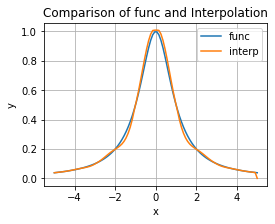

In [10]:
# Function to interpolate
def func(x):
    return 1 / (1 + x**2)

# Interpolation Points
interval = (-5, 5)
numPoints = 15
x0 = Chebyshev(*interval)(numPoints)
y0 = func(x0)

# Generate the matrix equation of Cubic Spline
polySpline = Spline(x0, y0)
mat, b = polySpline.generate(boundary="clamped")

# Condition number
print("--- Condition number ---")
for norm in ("1", "2", "infinity"):
    print("Cond-{} = ".format(norm), condition(mat, norm))

# Plot the interpolation polynomial
x = np.linspace(-5, 5, 100)
y = polySpline.interpolate(x)
fig = plt.figure(figsize=(4, 3))
plt.plot(x, func(x), label="func")
plt.plot(x, y, label="interp")
plt.title("Comparison of func and Interpolation")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

对三次样条插值系数方程组进行矩阵分解

In [11]:
def saveMat(mat, name):
    with open("save/"+name, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        if len(mat.shape) == 2:
            for row in mat:
                writer.writerow(np.array(row).ravel())
        if len(mat.shape) == 1:
            writer.writerow(mat)

saveMat(mat, "mat.csv")
saveMat(b, "b.csv")

# LU (unit-diag L)
L1, U1 = LU(mat, mode="L")
saveMat(L1, "L1.csv")
saveMat(U1, "U1.csv")

# LU (unit-diag U)
L2, U2 = LU(mat, mode="U")
saveMat(L2, "L2.csv")
saveMat(U2, "U2.csv")

# TDMA
L3, U3 = LU(mat, mode="TDMA")
saveMat(L3, "L3.csv")
saveMat(U3, "U3.csv")

# Cholesky
L4 = Cholesky(mat)
saveMat(L4, "L4.csv")

利用迭代法求解三次样条插值系数

In [12]:
recorder = {"Jacobi": [], "Gauss-Seidel": []}
xRef = np.linalg.solve(mat, b)
xJ = iterSolve(mat, b, method="Jacobi", tol=1e-4, recorder=recorder["Jacobi"])
xG = iterSolve(mat, b, method="Gauss-Seidel", tol=1e-4, recorder=recorder["Gauss-Seidel"])

print("xJ=\n", xJ, "\nxG=\n", xG)
print("xRef=\n", xRef)

saveMat(xRef, "xRef.csv")
saveMat(xJ, "xJ.csv")
saveMat(xG, "xG.csv")

Spectral Radius = 0.6754
Spectral Radius = 0.4562
xJ=
 [ 1.49376822e-04 -3.75890993e-04  2.52454529e-02 -2.08354895e-02
  1.07793616e-01 -9.66488044e-02  7.39331829e-01 -1.44917373e+00
  7.24638298e-01 -8.49910480e-02  9.61224525e-02 -1.32992206e-02
  1.88464303e-02  2.51297019e-03 -1.26615927e-03] 
xG=
 [ 1.49376824e-04 -3.75890991e-04  2.52454529e-02 -2.08354895e-02
  1.07793616e-01 -9.66488044e-02  7.39331829e-01 -1.44917373e+00
  7.24638298e-01 -8.49910480e-02  9.61224525e-02 -1.32992206e-02
  1.88464303e-02  2.51297019e-03 -1.26615927e-03]
xRef=
 [ 2.64276765e-04 -5.28553530e-04  2.54077426e-02 -2.09877215e-02
  1.07939575e-01 -9.67840481e-02  7.39455749e-01 -1.44928803e+00
  7.24738150e-01 -8.50807582e-02  9.61969593e-02 -1.33630325e-02
  1.88967453e-02  2.47260560e-03 -1.23630280e-03]


拟合迭代参差

In [13]:
from sklearn import linear_model
from sklearn.metrics import r2_score

steps1 = np.arange(1, len(recorder["Jacobi"]) + 1, dtype=np.int)
errJ = recorder["Jacobi"] / np.max(np.abs(xJ))
steps2 = np.arange(1, len(recorder["Gauss-Seidel"])+1, dtype=np.int)
errG = recorder["Gauss-Seidel"] / np.max(np.abs(xG))

fit1 = linear_model.LinearRegression().fit(steps1.reshape(-1, 1), np.log10(errJ.reshape(-1, 1)))
fit2 = linear_model.LinearRegression().fit(steps2.reshape(-1, 1), np.log10(errG.reshape(-1, 1)))

print("coef1 = ({:.4f}, {:.4f})".format(fit1.coef_.item(), fit1.intercept_.item()))
print("coef2 = ({:.4f}, {:.4f})".format(fit2.coef_.item(), fit2.intercept_.item()))

coef1 = (-0.3727, 0.1975)
coef2 = (-0.3727, 0.1975)


绘制迭代法的参差曲线

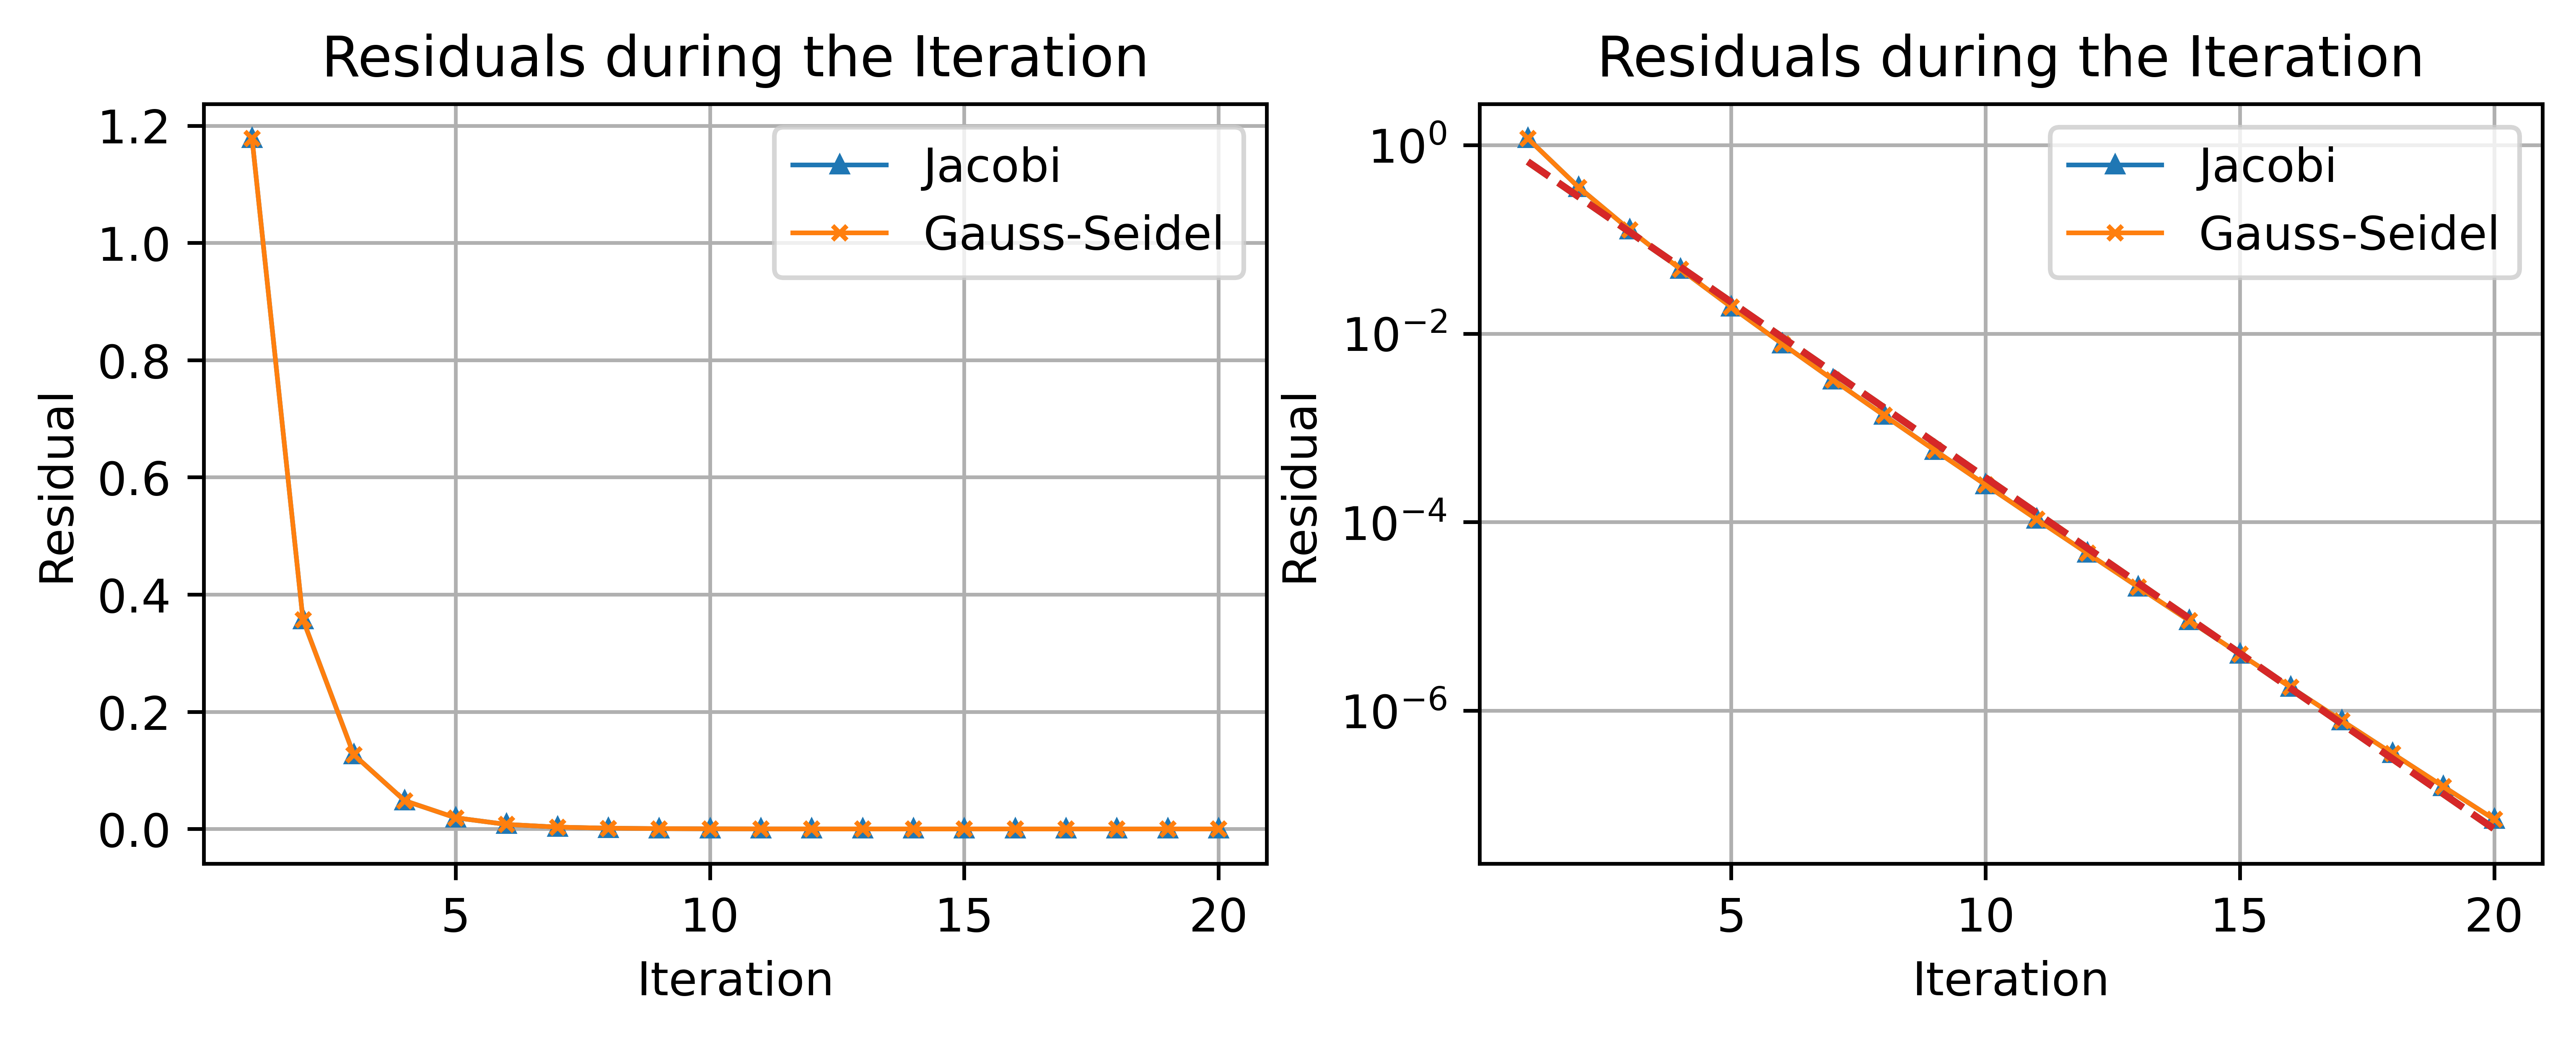

In [15]:
fig = plt.figure(figsize=(9,3), dpi=800)
ax = fig.subplots(1, 2)
for i in range(2):
    ax[i].plot(steps1, errJ, '^-', label="Jacobi", linewidth=1, markersize=3)
    ax[i].plot(steps2, errG, 'x-', label="Gauss-Seidel", linewidth=1, markersize=3)
    if i == 1:
        sample1 = np.linspace(steps1[0], steps1[-1], 100, endpoint=True)
        ax[i].plot(sample1, 10**fit1.predict(sample1.reshape(-1, 1)), "--")
        sample2 = np.linspace(steps2[0], steps2[-1], 100, endpoint=True)
        ax[i].plot(sample2, 10**fit2.predict(sample2.reshape(-1, 1)), "--")
        ax[i].set_yscale("log")
    ax[i].set_title("Residuals during the Iteration")
    ax[i].set_xlabel("Iteration")
    ax[i].set_ylabel("Residual")
    ax[i].legend()
    ax[i].grid()
plt.savefig("iterResidual.png", bbox_inches="tight")
plt.show()